# Developing a simulation methodology for the qSIP method

* Method:
  * qPCR simulation
    * mean quantifications derived from the absolute count data
    * variance derived from qSIP paper
    * values will be multiplied by taxon relative abundances (post-simulation subsampling) to get taxon-specific weighted averaged density differences (y_ijk)
  * Incorporation calculation
    * $\text{Buoyant density} = y_{ijk} = x_{jk}$
    * $\text{Total copies} = y_{ij} = \sum(y_{ijk})$
    * $\text{taxon density} = W_{ij} = \sum_{k=1}^{K} x_{jk} * \big(\frac{y_{ijk}}{y_{ij}}\big)$
    * $\text{density diff due to isotope incorp} = Z_i = W_{LABi} - W_{LIGHTi}$
      * each is mean across all replicates
      * need to simulate 3 replicates for control & treatment
  * Bootstrapping
    * sampling with replication of taxon abundances
      * sampling from all replicates in a treatment
    * estimated 90% CI bootstraps
      * value range encompassing 90% of bootstrap values
   

# Setting variables

In [1]:
supInfoFile = '/home/nick/notebook/SIPSim/dev/qSIP/PeerJ_qSIP_preprint/PeerJ_Supplemental_Information.pdf'

# Init

In [79]:
import os,sys
%load_ext rpy2.ipython

In [81]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: grid

  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Deriving qPCR variance from emperical data: qSIP pre-print

## pdf2txt method

In [57]:
pdfTextFile= os.path.splitext(supInfoFile)[0] + '.txt'

!pdf2txt.py $supInfoFile | perl -pe 's/\r+/ /g; s/[ \t ]+/\t/g' > $pdfTextFile

!head -n 4 $pdfTextFile
!printf '===============\n'
!tail -n 4 $pdfTextFile

1	
2	
3	
4	
652432.3	
268143.0	



In [48]:
!egrep "Table.+S2" $pdfTextFile

Table	S2.	qPCR	analysis	of	the	16S	gene	for	each	density	fraction	


### Making a parser was too painful; I just broke down and used a text editor & excel to parse out the table

In [77]:
tableS2File = pdfTextFile= os.path.splitext(supInfoFile)[0] + '_e.txt'
!head -n4 $tableS2File

SampleID	Tube	Glucose	Water	density-g-p-mL	16S-qPCR-copynum-p-ul
1.2	1	none	Nat_Abund	1.69581	195379.5
1.21	1	none	Nat_Abund	1.69249	282486
1.22	1	none	Nat_Abund	1.69139	310844.9


## Plotting data

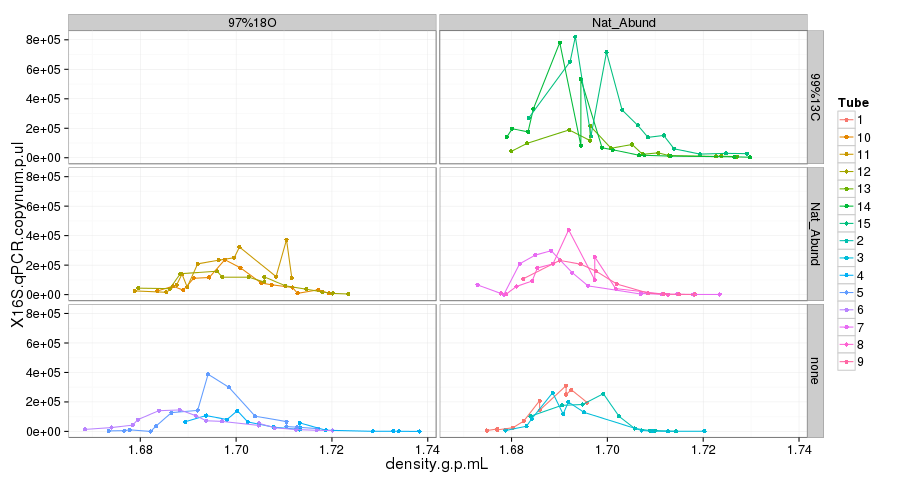

In [88]:
%%R -i tableS2File -w 900 

tbl.s2 = read.delim(tableS2File, sep='\t') %>%
    mutate(Tube = as.character(Tube))

ggplot(tbl.s2, aes(density.g.p.mL, X16S.qPCR.copynum.p.ul, color=Tube)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    facet_grid(Glucose ~ Water) +
    theme(
        text = element_text(size=16)
    )

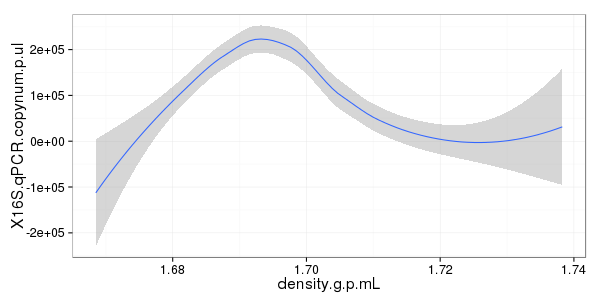

In [91]:
%%R -w 600 -h 300
ggplot(tbl.s2, aes(density.g.p.mL, X16S.qPCR.copynum.p.ul)) +
    geom_smooth() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Determining variance across a density window

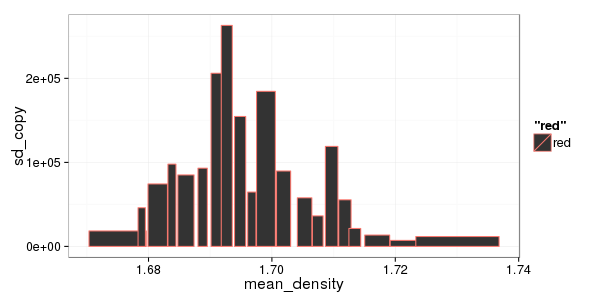

In [127]:
%%R -w 600 -h 300
tbl.s2.s = tbl.s2 %>%
    group_by(ntile(density.g.p.mL, 20)) %>%
    summarize(min_density = min(density.g.p.mL),
              mean_density = mean(density.g.p.mL),
              max_density = max(density.g.p.mL),
              density_width = max_density - min_density,
              var_copy = var(X16S.qPCR.copynum.p.ul),
              sd_copy = sd(X16S.qPCR.copynum.p.ul),
              mean_copy = mean(X16S.qPCR.copynum.p.ul))

ggplot(tbl.s2.s, aes(mean_density, sd_copy, color='red')) +
    geom_bar(stat='identity', aes(width=density_width)) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

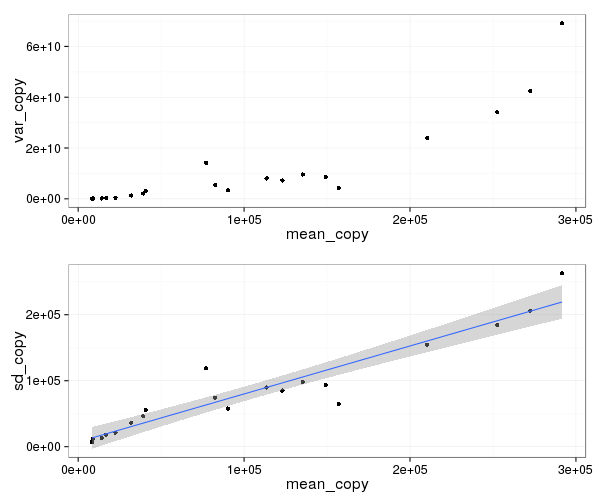

In [130]:
%%R -w 600 -h 500
# how does variance relate to mean copy number

p1 = ggplot(tbl.s2.s, aes(mean_copy, var_copy)) +
    geom_point() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

p2 = ggplot(tbl.s2.s, aes(mean_copy, sd_copy)) +
    geom_point() +
    geom_smooth(method='lm') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

grid.arrange(p1, p2, ncol=1)

### Linear regression of mean_copy_number ~ sd

In [129]:
%%R
res = lm(sd_copy ~ mean_copy, tbl.s2.s)
summary(res)


Call:
lm(formula = sd_copy ~ mean_copy, data = tbl.s2.s)

Residuals:
   Min     1Q Median     3Q    Max 
-56728  -6766  -2119   6101  55684 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.296e+03  8.167e+03   0.893    0.383    
mean_copy   7.269e-01  5.872e-02  12.380 3.05e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 23370 on 18 degrees of freedom
Multiple R-squared:  0.8949,	Adjusted R-squared:  0.8891 
F-statistic: 153.3 on 1 and 18 DF,  p-value: 3.048e-10



#### Notes:

* standard deviation varied more or less linearly with mean 


#### Implementation in modeling

* The qPCR values will be drawn from normal distributions representing posible value distribution 
  * normal dist mean (loc) = community total count value --> 'qPCR mean copy number' 
  * normal dist sd (scale) = community total count value --> 'qPCR mean copy number' --> sd copy number

# Bootstrapping

* How does the bootstrapping methodology work in the paper?

* Possibilities:
  * 

***
# OLD

In [74]:
def subInfo_parser(iFH):
    # parsing tableS2 from qSIP paper
    for line in iFH:
        if re.match('.+Table.+S2', line):
            tableS2_parser(iFH)

def tableS2_parser(iFH):
#    header = ('#SampleID', 'Tube', 'glucose', 'p-', '16S-')
#    is_header = lambda x: [x.startswith(y) for y in header]

    
    tableS2 = {}
    for line in iFH:
        if any(is_header(line)):
            parse
            
def parse_column(iFH):
    
    
    
            
            
with open(pdfTextFile, 'rb') as iFH:
    tableS2_parser(iFH)

#SampleID	

Tube	

glucose	

p-	�‐mL	

16S-	�‐qPCR-	�‐

p-	�‐uL	

